# Analysis of the Attack on the data generated by LIME, and oversampled using SMOTENC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from pathlib import Path
import os
import sys
import bz2
import pickle
np.random.seed(10)
# adds the visibility of the mlem module, needed to load the attack models
sys.path.append("../../../..") 
import mlem
from mlem.ensemble import HardVotingClassifier

In [2]:
import warnings

Here the oversampling has been made right after the generation of the data, using SMOTENC, bringing the proportion of the two classes to 50/50

In [3]:
BLACK_BOX_PATH = './BB_DATA/diva_rf_noclustering.bz2'
EXPERIMENTS_RESULTS_FOLDER = "/home/gerardozinno/Desktop/ExperimentsResult/DIVA_OVERSAMPLING_GENERATED_DATASET/gaussian/gaussian"
BLACK_BOX_DATA_PATH = './BB_DATA/diva_rf_noclustering_data_nsamples_5.npz'
TRAIN_SET_CSV = 'BB_DATA/train.csv'
TEST_SET_CSV  = 'BB_DATA/test.csv'
NOISY_VALIDATION_SET_CSV = 'BB_DATA/validation_noisy.csv'
CENTROIDS_NEIGHBORS = 'BB_DATA/clusters_representatives_quantiles_5_40.csv'

In [4]:
def get_attack_mod(index:int, targets=[0,1], base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the attack model was built
        targets (int | List(int)) - targets for the attack model.
    Returns:
        List containing the attack models (or model) for that particular index
    """
    if type(targets) is int:
        targets = [targets]
    loaded_models = []
    for t in targets:
        path = f"{base_folder}/{index}/attack/{t}/model.pkl.bz2"
        with bz2.BZ2File(path) as f:
            data = pickle.load(f)
            loaded_models.append(data)
    return loaded_models
        
def get_local_model(index:int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Local model
    """
    path = f"{base_folder}/{index}/black_box"
    local_model_path = f"{path}/model.pkl.bz2"
    with bz2.BZ2File(local_model_path) as lm:
        local_model = pickle.load(lm)
    return local_model

def get_local_model_data(index: int, base_folder=EXPERIMENTS_RESULTS_FOLDER):
    """
    Args:
        index - row of the dataset on which the local model was built.
    Returns:
        Structure with keys x and y
    """
    path = f"{base_folder}/{index}/black_box"
    data_path = f"{path}/data.npz"
    loaded = np.load(data_path, allow_pickle=True)
    return loaded

#def get_subset_target_cluster(df, target, cluster):
#    """
#    Returns the subset of a dataframe with the specified target and cluster.
#    """
#    tmp = df[df['Target'] == target]
#    return tmp[tmp['Cluster'] == cluster]

def get_subset_cluster(df, cluster):
    """
    Returns the subset of a dataframe with the specified Cluster.
    """
    return df[df['Cluster'] == cluster]

def split_probs_array(arr):
    """
    
    """
    n_classes = len(arr[0])
    separated = []
    max_index_row = np.argmax(arr, axis=1)
    for c in range(n_classes):
        separated.append(arr[max_index_row == c])
    return separated

loading the data and the black box

In [5]:
with bz2.BZ2File(BLACK_BOX_PATH) as f:
    black_box = pickle.load(f)
black_box

RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=100,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=150)

In [6]:
loaded = np.load(BLACK_BOX_DATA_PATH, allow_pickle=True)
for k in loaded.keys():
    print(k, end=" ")

x_train x_test y_train y_test x_test_clustered y_test_clustered 

In [7]:
x_train = loaded["x_train"]
x_test = loaded["x_test"]
y_train = loaded["y_train"]
y_test = loaded["y_test"]
x_test_clustered = loaded["x_test_clustered"]
y_test_clustered = loaded["y_test_clustered"]

In [9]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# Attack with the Hard Voting Classifier

In [14]:
print(f"{len(x_test_clustered)=}")

len(x_test_clustered)=40


In [15]:
ATTACK_0, ATTACK_1 = [], []

for index in range(len(x_test_clustered)):
    atk0, atk1 = get_attack_mod(index)
    ATTACK_0.append(atk0)
    ATTACK_1.append(atk1)
assert (len(ATTACK_0) == len(ATTACK_1)) and (len(ATTACK_0) == len(x_test_clustered))
        
ensemble_0 = HardVotingClassifier(classifiers=ATTACK_0)
ensemble_1 = HardVotingClassifier(classifiers=ATTACK_1)

In [16]:
diva_train = pd.read_csv(TRAIN_SET_CSV)
diva_test  = pd.read_csv(TEST_SET_CSV)

In [19]:
TRAIN = diva_train.drop('Target', axis=1)
TEST = diva_test.drop('Target', axis=1)

In [20]:
TRAIN_PREDICTIONS = black_box.predict_proba(TRAIN.to_numpy())
TEST_PREDICTIONS  = black_box.predict_proba(TEST.to_numpy())

In [21]:
TRAIN_PREDICTIONS_0 = TRAIN_PREDICTIONS[adult_train['Target'] == 0]
TRAIN_PREDICTIONS_1 = TRAIN_PREDICTIONS[adult_train['Target'] == 1]
TEST_PREDICTIONS_0 = TEST_PREDICTIONS[adult_test['Target'] == 0]
TEST_PREDICTIONS_1 = TEST_PREDICTIONS[adult_test['Target'] == 1]

In [22]:
IN_0 = ensemble_0.predict(TRAIN_PREDICTIONS_0)
IN_1 = ensemble_1.predict(TRAIN_PREDICTIONS_1)
OUT_0 = ensemble_0.predict(TEST_PREDICTIONS_0)
OUT_1 = ensemble_1.predict(TEST_PREDICTIONS_1)

In [23]:
INS = np.concatenate([IN_0, IN_1])
OUTS = np.concatenate([OUT_0, OUT_1])

In [24]:
number_outs = [x for x in OUTS if x == "out"]
number_even = [x for x in OUTS if x == "even"]
print(f"{len(number_outs)/len(OUTS)=}")
print(f"{len(number_even)/len(OUTS)=}")

len(number_outs)/len(OUTS)=0.09510390982740402
len(number_even)/len(OUTS)=0.0


In [25]:
INS_MASK = ['in'] * len(INS)
OUTS_MASK = ['out'] * len(OUTS)
INOUTS = np.concatenate([INS, OUTS])
EVEN_MASK = INOUTS != "even" # to mask away the even value

In [26]:
print(classification_report(np.array(INS_MASK + OUTS_MASK)[EVEN_MASK], INOUTS[EVEN_MASK]))

              precision    recall  f1-score   support

          in       0.71      0.96      0.82      6624
         out       0.49      0.10      0.16      2839

    accuracy                           0.70      9463
   macro avg       0.60      0.53      0.49      9463
weighted avg       0.64      0.70      0.62      9463



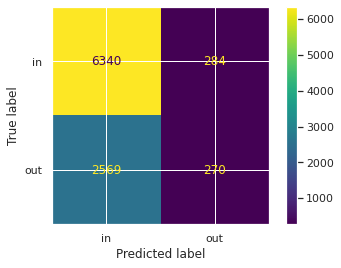

In [27]:
ConfusionMatrixDisplay.from_predictions(np.array(INS_MASK + OUTS_MASK)[EVEN_MASK], INOUTS[EVEN_MASK])

# Exploration of the Attack Models data

In [28]:
from mlem.utilities import load_pickle_bz2

In [30]:
ATTACK_MODELS_DATA = []
for i in range(40):
    atk_path = Path(EXPERIMENTS_RESULTS_FOLDER) / str(i) / "attack"
    d = {}
    d["row"] = i
    for i in (0,1):
        atk_path_i = atk_path / str(i)
        d[i] = {}
        d[i]["data"] = np.load(atk_path_i / "data.npz", allow_pickle=True)
        d[i]["model"] = load_pickle_bz2(atk_path_i / "model.pkl.bz2")
    ATTACK_MODELS_DATA.append(d)

In [31]:
r0 = ATTACK_MODELS_DATA[0]

In [32]:
print(*r0[0]['data'].keys())

x_train x_test y_train y_test


In [33]:
a = pd.DataFrame(r0[0]['data']['y_test']).value_counts(normalize=True)

In [34]:
a

in     0.75
out    0.25
dtype: float64

In [35]:
for row in ATTACK_MODELS_DATA:
    s = f"row={row['row']}"
    
    train_test = None
    for atk in (0,1):
        mod_data = row[atk]['data']
        train_y = pd.DataFrame(mod_data['y_train']).value_counts()
        train_y_n = pd.DataFrame(mod_data['y_train']).value_counts(normalize=True)
        test_y = pd.DataFrame(mod_data['y_test']).value_counts()
        test_y_n = pd.DataFrame(mod_data['y_test']).value_counts(normalize=True)

        
        s += f"\n\t{atk=}:\n\t\ttrain in/out = {train_y['in']}/{train_y['out']} | {train_y_n['in']:.2f}/{train_y_n['out']:.2f}"
        s += f"\n\t\ttest  in/out = {test_y['in']}/{test_y['out']}  | {test_y_n['in']:.2f}/{test_y_n['out']:.2f}"
            
    print(s)

row=0
	atk=0:
		train in/out = 8316/2772 | 0.75/0.25
		test  in/out = 2772/924  | 0.75/0.25
	atk=1:
		train in/out = 8316/2772 | 0.75/0.25
		test  in/out = 2772/924  | 0.75/0.25
row=1
	atk=0:
		train in/out = 8268/2757 | 0.75/0.25
		test  in/out = 2756/919  | 0.75/0.25
	atk=1:
		train in/out = 8268/2757 | 0.75/0.25
		test  in/out = 2756/919  | 0.75/0.25
row=2
	atk=0:
		train in/out = 8316/2772 | 0.75/0.25
		test  in/out = 2772/924  | 0.75/0.25
	atk=1:
		train in/out = 8316/2772 | 0.75/0.25
		test  in/out = 2772/924  | 0.75/0.25
row=3
	atk=0:
		train in/out = 8268/2757 | 0.75/0.25
		test  in/out = 2756/919  | 0.75/0.25
	atk=1:
		train in/out = 8268/2757 | 0.75/0.25
		test  in/out = 2756/919  | 0.75/0.25
row=4
	atk=0:
		train in/out = 8316/2772 | 0.75/0.25
		test  in/out = 2772/924  | 0.75/0.25
	atk=1:
		train in/out = 8316/2772 | 0.75/0.25
		test  in/out = 2772/924  | 0.75/0.25
row=5
	atk=0:
		train in/out = 8268/2757 | 0.75/0.25
		test  in/out = 2756/919  | 0.75/0.25
	atk=1:
		train in